# Algorithmic Post-Filtering

In this tutorial, we will demonstrate the use of `kontrol.regulator.post_filter` to add notch filters and low-pass filters
as post-filters for post-regulator designs.

We will inherit the a similar oscillatory plant from the "Algorithmic Control Design for Oscillator-Like Systems" tutorial.
In the plant, there're two oscillatory mode, one at 0.1 Hz and another at 1 Hz.

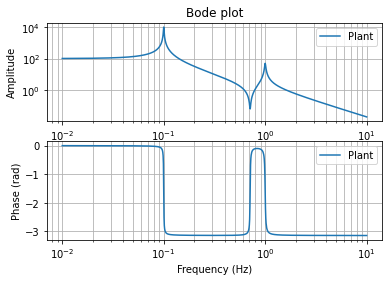

In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt
import kontrol.regulator

## define the plant here
s = control.tf("s")
g1 = 100
w1 = 0.1 * (2*np.pi)
q1 = 100
g2 = 1
w2 = 1 * (2*np.pi)
q2 = 50

plant = g1*w1**2 / (s**2 + w1/q1*s + w1**2) + g2*w2**2 / (s**2 + w2/q2*s + w2**2)

f = np.logspace(-2, 1, 1000)
plt.figure(figsize=(6, 4))
plt.subplot(211, title="Bode plot")
plt.loglog(f, abs(plant(1j*2*np.pi*f)), label="Plant")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(212)
plt.semilogx(f, np.angle(plant(1j*2*np.pi*f)), label="Plant")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")

Suppose we don't want to damp the 3 rad/s mode and we would like to add a second-order low-pass filter
to filter high frequency noise (Which doesn't exist in this tutorial but may exist in real systems).

We can use `kontrol.regulator.post_filter.post_notch()` to create a list of notch filters that completely cancels
the poles that we don't want to damp.
We need to specify the `plant`, the `regulator`, and `notch_peaks_above` parameters.
`notch_peaks_above` specifies the frequency threshold (in Hz).
`kontrol.regulator.post_filter.post_notch()` will return a list of notch filters to cancel modes above `notch_peaks_above`.

We can use `kontrol.regulator.post_filter.post_low_pass()` optimize a low-pass filter according to a specified phase margin (default 45 degrees).
We need to specify the `plant`, the `regulator`, any `post_filter`s such as the notches, and optionally, `ignore_ugf_above` parameters.
The function will optimize a cutoff frequency of a low-pass filter to make all unity gain frequencies (UGFs) lower than `ignore_ugf_above` to meet the specified phase margin.
If this is not specified, all UGFs are taken into account.
UGFs that are originally lower than the phase margin will be ignored.
The low-pass filter is defaulted to be `kontrol.regulator.predefined.low_pass()`, which is a simple $n^\mathrm{th}$-order low-pass filter.

Text(0.5, 0, 'Frequency (Hz)')

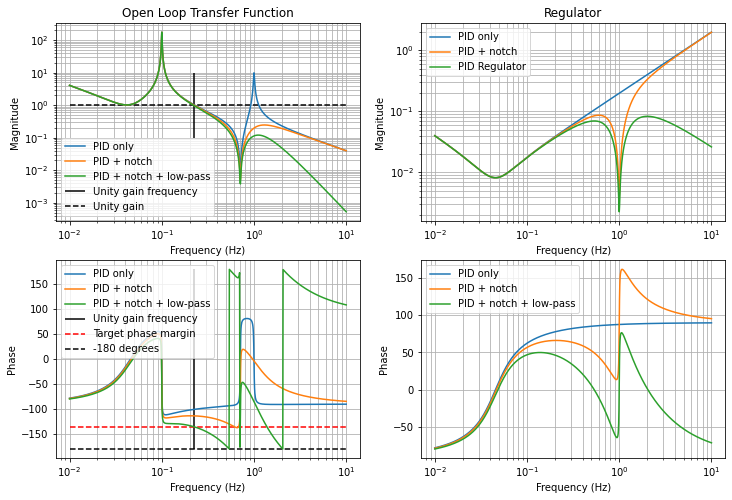

In [2]:
# Make regulator here
regulator = kontrol.regulator.oscillator.pid(plant, regulator_type="PID")

notch_peaks_above = 2 / (2*np.pi)  # We want to notch the 3 rad/s mode
ignore_ugf_above = None  # Let's just not ignore anything.

notch_list = kontrol.regulator.post_filter.post_notch(
    plant, regulator, notch_peaks_above=notch_peaks_above)
notch = np.prod(notch_list)  # Combine all notch filters

kwargs = {"order": 2}  # keyword arguments for kontrol.regulator.predefined.low_pass. We want 2nd-order low-pass.
low_pass = kontrol.regulator.post_filter.post_low_pass(
    plant, regulator, post_filter=notch, ignore_ugf_above=ignore_ugf_above, **kwargs)

oltf = regulator * plant
oltf_notch = regulator * plant * notch
_, pms, _, _, ugf, _ = control.stability_margins(oltf_notch, returnall=True)
# print(ugf/2/np.pi)
# print(pms)
oltf_notch_lp = regulator * plant * notch * low_pass

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title("Open Loop Transfer Function")
plt.loglog(f, abs(oltf(1j*2*np.pi*f)), label="PID only")
plt.loglog(f, abs(oltf_notch(1j*2*np.pi*f)), label="PID + notch")
plt.loglog(f, abs(oltf_notch_lp(1j*2*np.pi*f)), label="PID + notch + low-pass")
plt.vlines(ugf/2/np.pi, 0.1, 10, color="k", label="Unity gain frequency")
plt.hlines(1, min(f), max(f), ls="--", color="k", label="Unity gain")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

plt.subplot(222)
plt.title("Regulator")
plt.loglog(f, abs(regulator(1j*2*np.pi*f)), label="PID only")
# plt.loglog(f, abs((notch)(1j*2*np.pi*f)), label="Notch")
# plt.loglog(f, abs((low_pass)(1j*2*np.pi*f)), label="Low-pass")
plt.loglog(f, abs((regulator*notch)(1j*2*np.pi*f)), label="PID + notch")
plt.loglog(f, abs((regulator*notch*low_pass)(1j*2*np.pi*f)), label="PID Regulator")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

plt.subplot(223)
plt.semilogx(f, 180/np.pi*np.angle(oltf(1j*2*np.pi*f)), label="PID only")
plt.semilogx(f, 180/np.pi*np.angle(oltf_notch(1j*2*np.pi*f)), label="PID + notch")
plt.semilogx(f, 180/np.pi*np.angle(oltf_notch_lp(1j*2*np.pi*f)), label="PID + notch + low-pass")
plt.vlines(ugf/2/np.pi, -180, 180, color="k", label="Unity gain frequency")
plt.hlines(-135, min(f), max(f), ls="--", color="r", label="Target phase margin")
plt.hlines(-180, min(f), max(f), ls="--", color="k", label="-180 degrees")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase")
plt.xlabel("Frequency (Hz)")

plt.subplot(224)
plt.semilogx(f, 180/np.pi*np.angle(regulator(1j*2*np.pi*f)), label="PID only")
plt.semilogx(f, 180/np.pi*np.angle((regulator*notch)(1j*2*np.pi*f)), label="PID + notch")
plt.semilogx(f, 180/np.pi*np.angle((regulator*notch*low_pass)(1j*2*np.pi*f)), label="PID + notch + low-pass")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase")
plt.xlabel("Frequency (Hz)")